# Hyperparameters

In [1]:
IS_TRAINING_MODE = True

# training data paramters
TRAINING_PERCENT_PARAMETER = 0.15 #if IS_TRAINING_MODE else 0.015
DATA_PATH = '../data/big_data_bowl_2025'

# Development Parameters
DEBUG_PARAMETER = True
PARAM_FINAL_IMAGES = False
PARAM_GENERATE_CONFIDENCE_MATRIX = True

# Hyper parameters - these are from the last 15% run
sfs_features_to_select = 3
gradient_boost__n_estimators = 32

# Best Params for All Hyperparameters
logistic_regression__C = 1.0
logistic_regression__class_weight = None
logistic_regression__fit_intercept = True
logistic_regression__penalty = 'l2'
logistic_regression__solver = 'newton-cholesky'
kneighbors__algorithm = 'auto'
kneighbors__n_neighbors = 10
kneighbors__weights = None
decision_tree__criterion = 'entropy'
decision_tree__max_depth = 6
decision_tree__max_features = None
random_forest__max_features = 6
random_forest__n_estimators = 3
logistic_regression__features = ['yardsToGo', 'rb_count', 'extra_ol', 'form_I_FORM', 'form_JUMBO', 'form_PISTOL', 'form_SINGLEBACK', 'form_VICTORY', 'form_WILDCAT', ]
kneighbors__features = ['extra_ol', 'form_EMPTY', 'form_JUMBO', 'form_MUDDLE', 'form_SHOTGUN', 'quarter_5', ]
decision_tree__features = ['rb_count', 'on_schedule', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_VICTORY', 'down_1', 'down_2', ]
support_vector__features = ['rb_count', 'on_schedule', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_VICTORY', ]

# Initializing Data

## Preparing Data

In [2]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.utils import shuffle

from sklearn import tree

import pandas as pd
import numpy as np
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score , confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector

# HalvingGridSearchCV is experimental and the API might change without any deprecation cycle
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import auc as skl_auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [3]:
plays_path = f'{DATA_PATH}/plays.csv'
plays = pd.read_csv(plays_path)

plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [4]:
games_path = f'{DATA_PATH}/games.csv'
games = pd.read_csv(games_path)

plays = plays.merge(games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], left_on='gameId', right_on='gameId')
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,homeTeamAbbr,visitorTeamAbbr
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone,CIN,ATL
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone,DAL,CIN
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone,HOU,TEN
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone,KC,TEN
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man,TB,BAL


## Readying the dataset

In [5]:
def get_position_features(s: pd.Series) -> pd.Series:
    ### determine wr, te, rb based on alignment; WRxTE
    wr_count = te_count = rb_count = 0
    extra_ol = s.offenseFormation == "JUMBO"
    if not isinstance(s.receiverAlignment, float):
        alignment = s.receiverAlignment.split('x')
        if len(alignment):
            wr_count = int(alignment[0])
            te_count = int(alignment[1])
            rb_count = 5 - wr_count - te_count
            if extra_ol and rb_count > 1:
                rb_count -= 1 

    return pd.Series([wr_count, te_count, rb_count, extra_ol], ['wr_count', 'te_count', 'rb_count', 'extra_ol'])
def get_time_features(s: pd.Series) -> pd.Series:
    ### determine total time remaining, is overtime, or within two mins 
    two_min_1st_half = 32 * 60
    two_min_2st_half = 2 * 60
    two_min_overtime = 68 * 60
    
    quarter = int(s.quarter)
    secs_remaining = math.nan
    is_inside_two_mins = is_overtime = False
    quarter_clock = s.gameClock.split(':')
    if len(quarter_clock) == 2:
        secs_in_quarter = int(quarter_clock[0]) * 60 + int(quarter_clock[1])
        if quarter <= 4:
            secs_remaining = (4 - quarter) * 15 * 60 + secs_in_quarter
        else:
            secs_remaining = secs_in_quarter
            is_overtime = True
        is_inside_two_mins = secs_in_quarter <= 120 and (quarter == 2 or quarter >= 4)

    return pd.Series([secs_remaining, is_inside_two_mins, is_overtime], ['secs_remaining', 'is_inside_two_mins', 'is_overtime'])

# v1 result - just sneak, kneel, spikie, pass, or run
plays['play_result'] = plays.apply(lambda p: 
                                   'run' if p.qbSneak == True else 
                                   'run' if p.qbKneel == True else 
                                   'pass' if p.qbSpike == True else 
                                   'pass' if p.isDropback == True else 
                                   'run', axis = 1)

# offenseFormation is NaN for qb kneels or spikes
plays['offense_formation'] = plays.apply(lambda p: 
                                   'VICTORY' if p.qbKneel == True else
                                   'MUDDLE' if p.qbSpike == True else
                                   p.offenseFormation, axis = 1)

# offense is considered on schedule if they gain at least 50% on first down, 70% on second down, or 100% on 3rd/4th. 
# this means on schedule is 1st (yards <= 10), 2nd (yards <= 5), 3rd (yards <= 3), 4th (yards <= 1)
plays['on_schedule'] = plays.apply(lambda p: 
                                   p.yardsToGo <= 10 if p.down == 1 else
                                   p.yardsToGo <= 5  if p.down == 2 else
                                   p.yardsToGo <= 3  if p.down == 3 else
                                   p.yardsToGo <= 1  if p.down == 4 else
                                   False, axis = 1)
# anything two yards or less is considered short yardage
plays['and_short'] = plays.apply(lambda p: p.yardsToGo <= 2, axis = 1)


# get score and win probability
plays['score_offset'] = plays.apply(lambda p: 
                                    p.preSnapHomeScore - p.preSnapVisitorScore if p.possessionTeam == p.homeTeamAbbr else
                                    p.preSnapVisitorScore - p.preSnapHomeScore, axis = 1)
plays['win_probability'] = plays.apply(lambda p: 
                                       p.preSnapHomeTeamWinProbability if p.possessionTeam == p.homeTeamAbbr else
                                       p.preSnapVisitorTeamWinProbability, axis = 1)

# come back to this - the logic is a bit recursive here
# plays['high_liklihood_pass'] = plays.apply(lambda p: 
#                                             True if p.qbSpike == True else
#                                             False if p.qbKneel == True else
#                                             True if 
#                                             'UNKNOWN' if p.qbKneel == True else
#                                             p.offenseFormation, axis = 1)

# get position counts (TE, WR, etc)
tmp = plays.apply(get_position_features, axis=1)
plays['wr_count'] = tmp['wr_count']
plays['te_count'] = tmp['te_count']
plays['rb_count'] = tmp['rb_count']
plays['extra_ol'] = tmp['extra_ol']

tmp = plays.apply(get_time_features, axis=1)
plays['secs_remaining'] = tmp['secs_remaining']
plays['is_inside_two_mins'] = tmp['is_inside_two_mins']
plays['is_overtime'] = tmp['is_overtime']

plays['off_yards_to_goal'] = plays.apply(lambda p: 100 - int(p.yardlineNumber) if p.yardlineSide == p.possessionTeam else int(p.yardlineNumber), axis = 1)
df = plays

## Prepare the training set

In [6]:
formation_dummies = pd.get_dummies(df.offense_formation, prefix='form')
df = pd.concat([df, formation_dummies], axis=1)
quarter_dummies = pd.get_dummies(df.quarter, prefix='quarter')
df = pd.concat([df, quarter_dummies], axis=1)
down_dummies = pd.get_dummies(df.down, prefix='down')
df = pd.concat([df, down_dummies], axis=1)
# teams_dummies = pd.get_dummies(df.possessionTeam, prefix='team')                              # not using team dummies at the moment
# df = pd.concat([df, teams_dummies], axis=1)

TARGET_FEATURE = 'play_result'
TRAINING_FEATURES = ['yardsToGo',                                                               # down and distance
                     #'quarter', 'is_overtime', 'down',                                         # covered by dummies
                     'secs_remaining', 'is_inside_two_mins',                                    # game time
                     'wr_count', 'te_count', 'rb_count', 'extra_ol',                            # formations
                     #'possessionTeam',                                                         # including team
                     'on_schedule', 'and_short',                                                # situational
                     'score_offset', 'win_probability',                                         # score and win probability
                     TARGET_FEATURE]
for c in formation_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in quarter_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in down_dummies.columns:
    TRAINING_FEATURES.append(c)
# for c in teams_dummies.columns:
#     TRAINING_FEATURES.append(c)

df[TRAINING_FEATURES]

,yardsToGo,secs_remaining,is_inside_two_mins,wr_count,te_count,rb_count,extra_ol,on_schedule,and_short,score_offset,...,form_WILDCAT,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4
0,10,1014,False,3,2,0,False,True,False,18,...,False,False,False,True,False,False,True,False,False,False
1,10,133,False,3,2,0,False,True,False,0,...,False,False,False,False,True,False,True,False,False,False
2,12,120,True,2,2,1,False,False,False,-14,...,False,False,False,False,True,False,False,False,True,False
3,10,3268,False,2,2,1,False,False,False,0,...,False,True,False,False,False,False,False,True,False,False
4,8,1036,False,3,1,1,False,False,False,0,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,4,2569,False,2,2,1,False,False,False,-10,...,False,False,True,False,False,False,False,False,True,False
16120,10,752,False,2,2,1,False,True,False,2,...,False,False,False,False,True,False,True,False,False,False
16121,10,1499,False,2,2,1,False,True,False,4,...,False,False,False,True,False,False,True,False,False,False
16122,10,2745,False,2,2,1,False,True,False,4,...,False,True,False,False,False,False,True,False,False,False


In [7]:
tmp = df[TRAINING_FEATURES]
X_train, X_test, y_train, y_test = train_test_split(tmp.drop(TARGET_FEATURE, axis = 1), 
                                                    tmp[TARGET_FEATURE],
                                                    train_size=TRAINING_PERCENT_PARAMETER,
                                                    random_state=27,
                                                    stratify = df[TARGET_FEATURE],
                                                    shuffle=True)
if DEBUG_PARAMETER:
    print(f"The training set has {len(y_train)} rows")
    print(f"The test set has {len(y_test)} rows")
    print(f"The target feature is {TARGET_FEATURE} and the {len(X_train.columns)} training columns are {[x for x in X_train.columns]}")

The training set has 2418 rows
The test set has 13706 rows
The target feature is play_result and the 29 training columns are ['yardsToGo', 'secs_remaining', 'is_inside_two_mins', 'wr_count', 'te_count', 'rb_count', 'extra_ol', 'on_schedule', 'and_short', 'score_offset', 'win_probability', 'form_EMPTY', 'form_I_FORM', 'form_JUMBO', 'form_MUDDLE', 'form_PISTOL', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_VICTORY', 'form_WILDCAT', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'down_1', 'down_2', 'down_3', 'down_4']


## Automation Layer

In [8]:
# def create_confusion_matrix(model_name, predictions, y_test):
#     cm = confusion_matrix(predictions, y_test)
#     sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 20}, cbar = False)
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.title(f'Confusion matrix for {model_name}')
#     sns.set(font_scale = 2)
    
# def create_confusion_matrix_2(model_name, predictions, y_test):
#     cm = confusion_matrix(predictions, y_test)
#     disp1 = ConfusionMatrixDisplay(cm, display_labels=['run', 'pass' ])
#     disp1.plot()
#     plt.title("Logistic Regression Confusion Matrix")
    
def create_roc_curve(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc_value = skl_auc(fpr, tpr)

    disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp2.plot()

all_best_params = {}
def print_best_params(name, best_params):
    if IS_TRAINING_MODE:
        return
    print(f"======== Best Params for {name} ========")
    for key in best_params:
        value = best_params[key]
        if not isinstance(value, str):
            print(f"{key} = {value}")
        else:
            print(f"{key} = '{value}'")

def append_best_params(name, best_params):
    all_best_params.update(best_params)
    print_best_params(name, best_params)

all_runs = []
best_run = None
class ModelTrainer:
    def __init__(self, model_name, actual_model, prefix, generate_charts=True, selected_features=None):
        self.start_time = time.time()
        self.model_name = model_name
        self.model = actual_model
        self.prefix = prefix
        self.generate_charts = False #generate_charts
        self.training_features = None
        self.train_time = None
        self.train_accuracy = None
        self.test_accuracy = None
        self.features = selected_features if selected_features is not None else [x for x in TRAINING_FEATURES if x != TARGET_FEATURE]
        
    def elapsed(self):
        elapsed_time = time.time() - self.start_time
        return f"{elapsed_time:.4f} secs"
    
    def model_predict(self, X, is_continuous):
        prediction = self.model.predict(X)
        if is_continuous:
            prediction = (prediction >= 0.5).astype(int)
        return prediction
    
    def chart_roc_and_confusion(self, is_continuous):
        fig, ax = plt.subplots(1, 2)
        if PARAM_FINAL_IMAGES:
            fig.set_size_inches(20, 12)
        else:
            fig.set_size_inches(15, 5)

        preds = self.model_predict(X_test[self.features], is_continuous)

        # Confusion Matrix
        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            conf_matrix = confusion_matrix(y_test, preds)
            disp1 = ConfusionMatrixDisplay(conf_matrix, display_labels=['run', 'pass' ])
            # plt.title("Confusion Matrix")
            disp1.plot(ax=ax[0])
            print(f"Precision: {precision_score(y_test, preds, labels=['run', 'pass' ], pos_label='run'):.4f}")
            print(f"Recall: {recall_score(y_test, preds, labels=['run', 'pass' ], pos_label='run'):.4f}")            

        # ROC Curve
        y_score = None
        if not is_continuous:
            y_score = self.model.predict_proba(X_test[self.features])[:, 1]
        else:
            y_score = self.model.predict(X_test[self.features])
        fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='run') # 
        roc_auc_value = skl_auc(fpr, tpr)

        disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
        disp2.plot(ax=ax[1])
    
    def run(self, is_continuous=False):
        features = self.features
        global best_run
        if not IS_TRAINING_MODE:
            print("Not training models - IS_TRAINING_MODE=False")
            return
        training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1

        model = self.model
        model.fit(X_train[features], y_train)
        predictions = model.predict(X_test[features])
        train_accuracy = accuracy_score(model.predict(X_train[features]), y_train)
        test_accuracy = accuracy_score(predictions, y_test) 
        self.training_features = training_features
        self.train_time = self.elapsed()
        self.train_accuracy = train_accuracy
        self.test_accuracy = test_accuracy
        if self.prefix is not None:
            X_test[f'{self.prefix}_pred'] = predictions
        all_runs.append(self)
        if best_run is None or self.test_accuracy > best_run.test_accuracy:
            best_run = self

        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            self.chart_roc_and_confusion(False)

def optimize_model_params(pipeline, parameters_to_try):
    if IS_TRAINING_MODE:
        print("Not optimizing hyper parameters - IS_TRAINING_MODE=True")
        return
    model_finder = GridSearchCV(estimator = pipeline, 
                                param_grid = parameters_to_try, 
                                scoring = "accuracy",
                                n_jobs=-1,      # parallelization
                                cv = 5)
    model_finder.fit(X_train, y_train)
    append_best_params("LogisticRegression", model_finder.best_params_)

def show_run_output():
    if not IS_TRAINING_MODE:
        return
    print(f"*Best Run is {best_run.test_accuracy:4f} from {best_run.model_name}*\n")
    print("| Model | Features | Train Time | Train Accuracy | Test Accuracy |")
    print("| ----- | -------- | ---------- | -------------  | -----------   |")
    for r in all_runs:
        print(f"| {r.model_name} | {r.training_features} | {r.train_time} | {r.train_accuracy:4f} | {r.test_accuracy:4f} |")

all_best_features = []
def find_best_features(sq_model, prefix, max_features=10):
    if IS_TRAINING_MODE:
        print("Not optimizing hyper parameters - IS_TRAINING_MODE=True")
        return
    best_accuracy = 0.0
    best_features = []

    for num_features in range(1, max_features + 1):
        start = time.time()
        selector = SequentialFeatureSelector(estimator=sq_model, n_features_to_select=num_features, n_jobs=-1)
        pipeline = Pipeline([
            # ('scaler', StandardScaler()),
            ('sequential', selector)
        ])
        X_sfs = pipeline.fit_transform(X_train, y_train)

        best_columns = selector.get_feature_names_out()

        sq_model.fit(X_train[best_columns], y_train)
        # train_accuracy = accuracy_score(sq_model.predict(X_train[best_columns]), y_train)
        test_accuracy = accuracy_score(sq_model.predict(X_test[best_columns]), y_test) 

        elapsed_time = time.time() - start
        print(f"Best Training Accuracy for {num_features}: {test_accuracy:4f} in {elapsed_time:.4f} secs, features: {selector.get_feature_names_out()}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_features = selector.get_feature_names_out()
    print(f"\nOverall Best: {best_accuracy:4f} features: {best_features}")
    output = f"{prefix}__features = ["
    for feature in best_features:
        output += f"'{feature}', "
    output += "]"
    all_best_features.append(output)
    return best_features

def print_best_features():
    for best_feature in all_best_features:
        print(best_feature)


## EDA

### Expectation: Teams pass substantially more in the last two minutes of each half

In [9]:
df['pass_percent'] = df.apply(lambda p: 1 if p.play_result == "pass" else 0, axis = 1)
df['mins_in_half'] = df.apply(lambda p: 30 - math.ceil(p.secs_remaining / 60), axis = 1)

pass_by_min = df.loc[(df.quarter < 3), ['mins_in_half', 'pass_percent'] ].groupby(['mins_in_half']).mean('pass_percent').reset_index()

px.scatter(pass_by_min, x='mins_in_half', y='pass_percent', trendline='ols', title='Percentage of Passing Plays by Time Remaining in First Half')

In [10]:
df['mins_in_half'] = df.apply(lambda p: 60 - math.ceil(p.secs_remaining / 60), axis = 1)

pass_by_min = df.loc[(df.quarter == 3) | (df.quarter == 4), ['mins_in_half', 'pass_percent'] ].groupby(['mins_in_half']).mean('pass_percent').reset_index()

px.scatter(pass_by_min, x='mins_in_half', y='pass_percent', trendline='ols', title='Percentage of Passing Plays by Time Remaining in Second Half')

### Expectation: Teams pass more based on how much they are winning or losing

In [11]:
score_and_result = df.loc[df.quarter_1 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the First Quarter')

In [12]:
df['pass_percent'] = df.apply(lambda p: 1 if p.play_result == "pass" else 0, axis = 1)
score_and_result = df.loc[df.quarter_2 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the Second Quarter')

In [13]:
score_and_result = df.loc[df.quarter_3 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the Third Quarter')

In [14]:
score_and_result = df.loc[df.quarter_4 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the Fourth Quarter')

# Determine Hyperparameters

### Logistic Regression

In [15]:
pipeline = Pipeline([
    ('logistic_regression', LogisticRegression(max_iter=10000))
])
parameters_to_try = {
    'logistic_regression__fit_intercept': [True, False],
    'logistic_regression__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'logistic_regression__C': [1.0, 100.0, 10000.0],
    'logistic_regression__class_weight': [None, 'balanced'],
    'logistic_regression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [16]:
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)
features = find_best_features(model, "logistic_regression")

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### K-Nearest Neighbors

In [17]:
pipeline = Pipeline([
    ('kneighbors', KNeighborsClassifier())
])
parameters_to_try = {
    'kneighbors__n_neighbors': np.array(range(1, 20)),
    'kneighbors__weights': [None, 'uniform', 'distance'],
    'kneighbors__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'kneighbors__leaf_sizeint': ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [18]:
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
features = find_best_features(model, "kneighbors")

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Decision Tree

In [19]:
pipeline = Pipeline([
    ('decision_tree', DecisionTreeClassifier(criterion='entropy'))
])
parameters_to_try = {
    'decision_tree__criterion': ['gini', 'entropy', 'log_loss'],
    'decision_tree__max_depth': np.array(range(1, 20)),
    'decision_tree__max_features': [None, 'sqrt', 'log2'],
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [20]:
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
features = find_best_features(model, "decision_tree")

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Support Vector Machines

In [21]:
# pipeline = Pipeline([
#     ('support_vector', SVC(probability=False))        # avoid applying expensive Platt's calibration internally
# ])
# parameters_to_try = {
#     'support_vector__C': [0.1, 10, 1000], 
# 	'support_vector__gamma': [0.1, 10, 100], # 1, 0.1, 0.01, 0.001, 0.0001
# 	'support_vector__kernel': ['poly']
# }

# optimize_model_params(pipeline, parameters_to_try)

In [22]:
model = SVC()
features = find_best_features(model, "support_vector")

# Overall Best: 0.742667 features: ['rb_count' 'on_schedule' 'form_SHOTGUN' 'form_SINGLEBACK' 'form_VICTORY']

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Random Forest

In [23]:
pipeline = Pipeline([
    ('random_forest', RandomForestClassifier(n_estimators=5, max_features=10, oob_score=True))
])
parameters_to_try = {
    'random_forest__n_estimators': np.array(range(1, 5)),
    'random_forest__max_features': np.array(range(1, 10)),
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


[0.6344086021505376, 0.6679073614557486, 0.6815550041356493, 0.7038875103391232, 0.7043010752688172, 0.7092638544251447, 0.71712158808933, 0.7237386269644334, 0.7196029776674938, 0.717948717948718, 0.717535153019024, 0.71712158808933, 0.717535153019024]


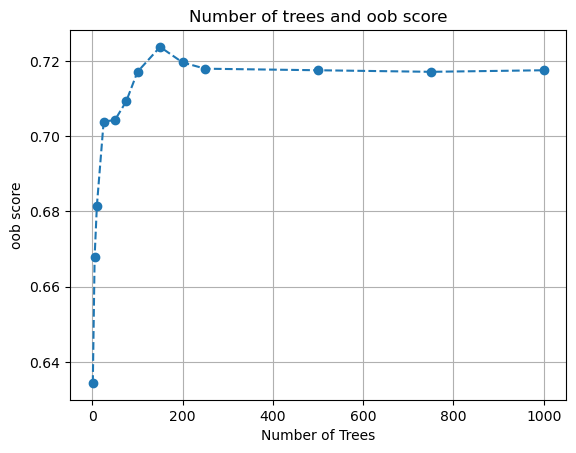

In [24]:
n_trees = [1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 750, 1000]

### GRADED
oob_scores = []
accuracy = []
for i in n_trees:
    f = RandomForestClassifier(random_state=42, n_estimators=i, oob_score=True).fit(X_train, y_train)
    oob_scores.append(f.oob_score_)
    accuracy.append(accuracy_score(f.predict(X_test), y_test))

### ANSWER CHECK
print(oob_scores)

plt.plot(n_trees, oob_scores, '--o')
plt.grid()
plt.title('Number of trees and oob score')
plt.xlabel('Number of Trees')
plt.ylabel("oob score");

[0.658981467970232, 0.690646432219466, 0.7042900919305414, 0.7120968918721727, 0.7128264993433533, 0.7137020283087698, 0.7164015759521377, 0.7150153217568948, 0.7156719684809573, 0.7145775572741865, 0.7168393404348461, 0.7166204581934918, 0.7171311834233183]


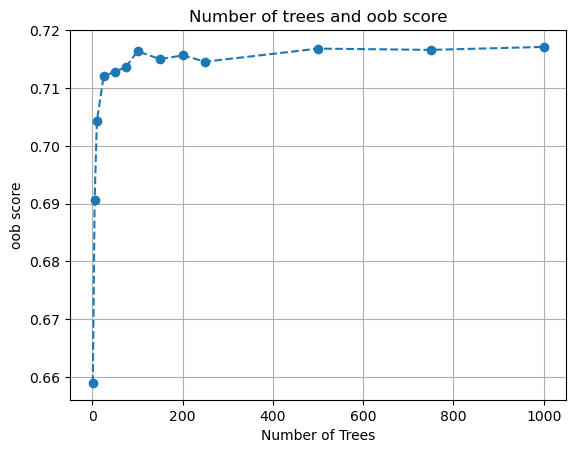

In [25]:
print(accuracy)

plt.plot(n_trees, accuracy, '--o')
plt.grid()
plt.title('Number of trees and oob score')
plt.xlabel('Number of Trees')
plt.ylabel("oob score");

### Gradient Boosting Ensemble

[0.7423026411790457, 0.7415000729607472, 0.7414271122136291, 0.7418648766963374, 0.7425944841675178, 0.7422296804319276, 0.7432511308915803, 0.7436888953742886, 0.7439077776156428, 0.7433970523858164, 0.7433240916386984, 0.7434700131329345, 0.7433970523858164, 0.7436888953742886, 0.7431781701444623, 0.7444185028454692, 0.7442725813512331, 0.7449292280752955, 0.7446373850868233, 0.7446373850868233, 0.7457317962935941, 0.7462425215234204, 0.7464614037647745, 0.7458777177878302, 0.7462425215234204, 0.7458777177878302, 0.7460236392820663, 0.7460236392820663, 0.7457317962935941, 0.7451481103166496, 0.7448562673281774, 0.7450021888224135, 0.7443455420983511, 0.7450021888224135, 0.7447833065810594, 0.7448562673281774, 0.7450021888224135, 0.7443455420983511, 0.7441266598569969, 0.7443455420983511]
[0.7423026411790457, 0.7415000729607472, 0.7414271122136291, 0.7418648766963374, 0.7425944841675178, 0.7422296804319276, 0.7432511308915803, 0.7436888953742886, 0.7439077776156428, 0.7433970523858164

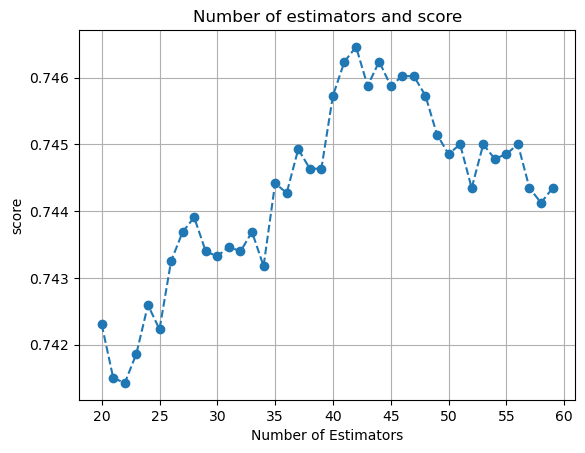

In [26]:
gbc_estimators = np.array(range(20, 60))
gbc_scores = []
gbc_accuracy = []
for i in gbc_estimators:
    gbc = GradientBoostingClassifier(n_estimators=i)
    gbc.fit(X_train, y_train)
    gbc_score = gbc.score(X_test, y_test)
    gbc_scores.append(gbc_score)
    gbc_accuracy.append(accuracy_score(gbc.predict(X_test), y_test))

### ANSWER CHECK
print(gbc_scores)
print(gbc_accuracy)

plt.plot(gbc_estimators, gbc_scores, '--o')
plt.grid()
plt.title('Number of estimators and score')
plt.xlabel('Number of Estimators')
plt.ylabel("score");

# Runtime Models

### Baseline

Precision: 0.0000
Recall: 0.0000


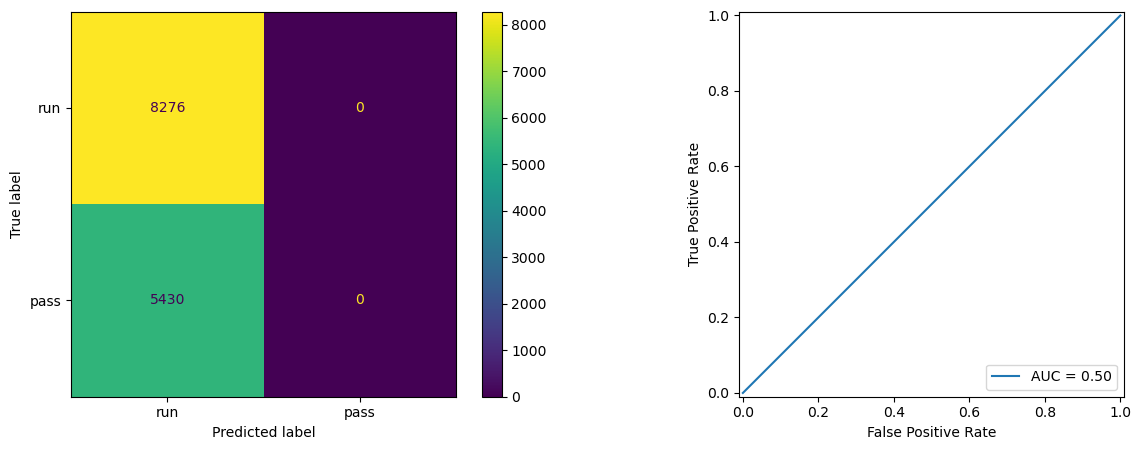

In [27]:
modeller = ModelTrainer(
    "Dummy", 
    DummyClassifier(),
    None
)
modeller.run()

### Logistic Regression

Precision: 0.6870
Recall: 0.6486


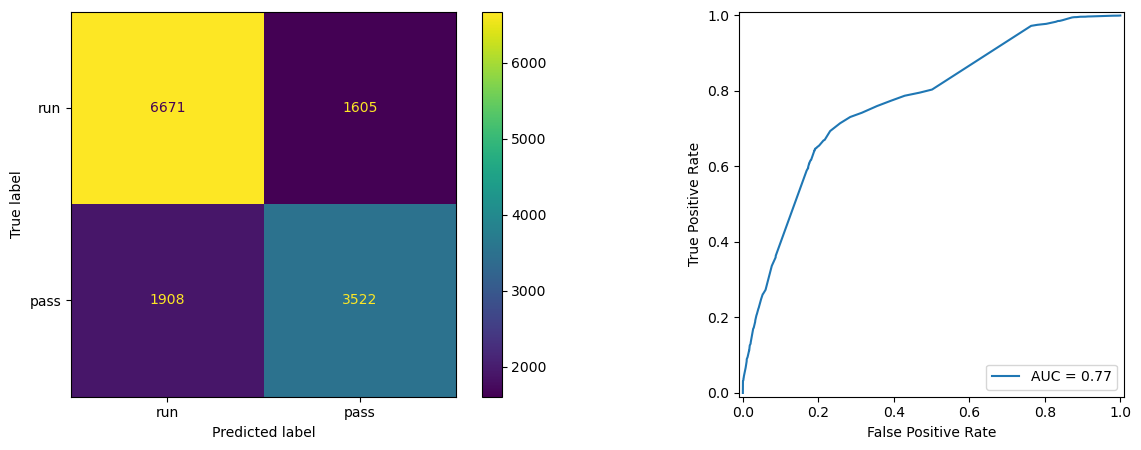

In [28]:
model_name = f"LogisticRegression (fit_intercept = {logistic_regression__fit_intercept}, penalty = {logistic_regression__penalty}, C = {logistic_regression__C}, class_weight = {logistic_regression__class_weight}, solver = {logistic_regression__solver})"
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)

ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            "lr",
            selected_features=logistic_regression__features).run()

### K-Nearest Neighbors

Precision: 0.6853
Recall: 0.6378


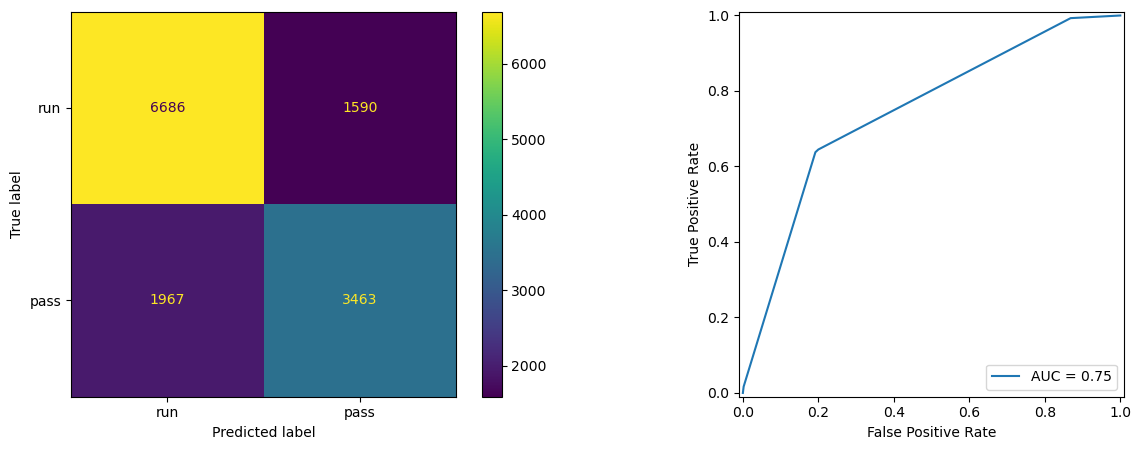

In [29]:
model_name = f"K-Nearest Neighbors (algorithm = {kneighbors__algorithm}, n_neighbors = {kneighbors__n_neighbors}, weights = {kneighbors__weights})"
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            "kn",
            selected_features=kneighbors__features).run()

### Decision Tree

Precision: 0.6843
Recall: 0.6521


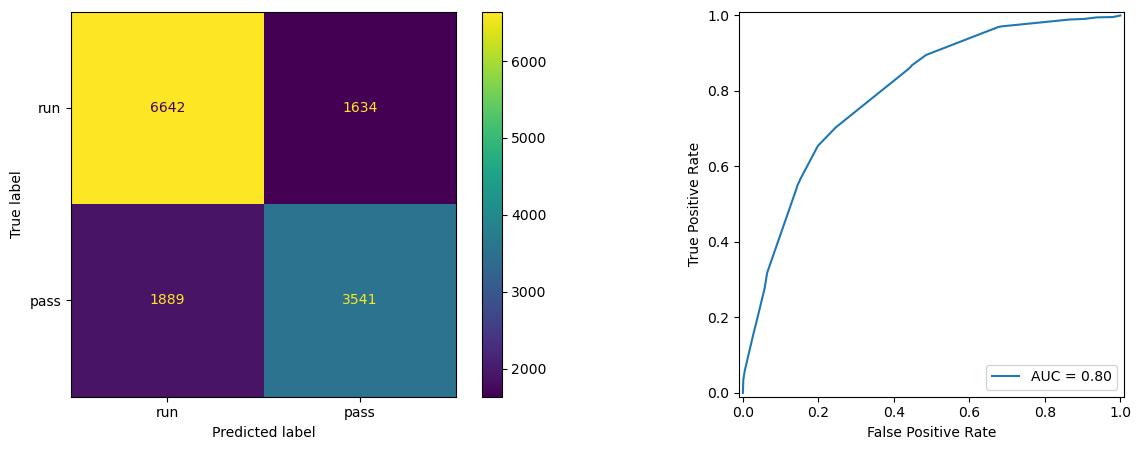

In [30]:
# for max_depth in range(1, 30):
model_name = f"DecisionTreeClassifier with (criterion={decision_tree__criterion}, max_depth={decision_tree__max_depth}, max_features={decision_tree__max_features})"
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "dt",
            selected_features=decision_tree__features).run()

### Support Vector Machines

Precision: 0.6513
Recall: 0.6856


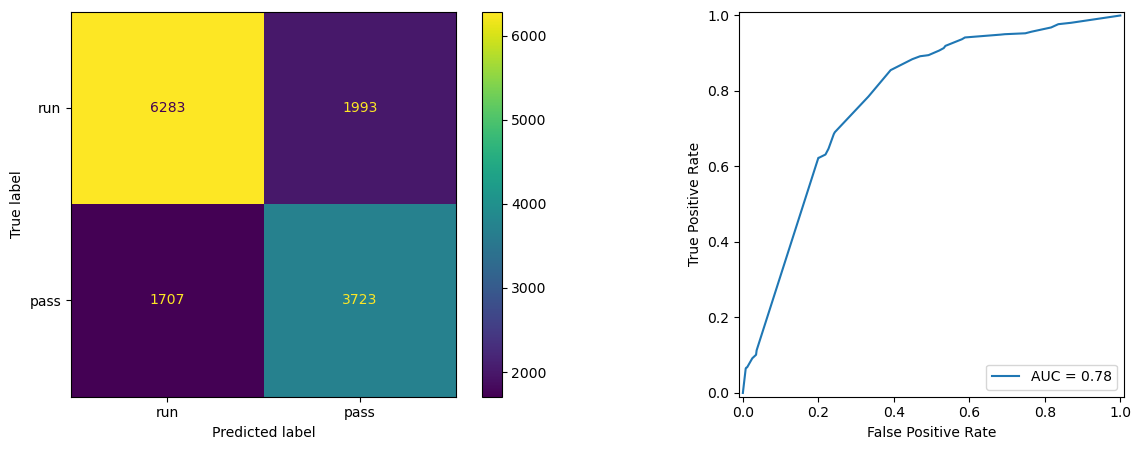

In [31]:
svc = SVC() #kernel=PARAM_SVM_KERNEL, gamma=PARAM_SVM_GAMMA, C=PARAM_SVM_C)
model_name = f"SVM (default params)"

ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "sv").run()

### Random Forest

Precision: 0.6041
Recall: 0.6401


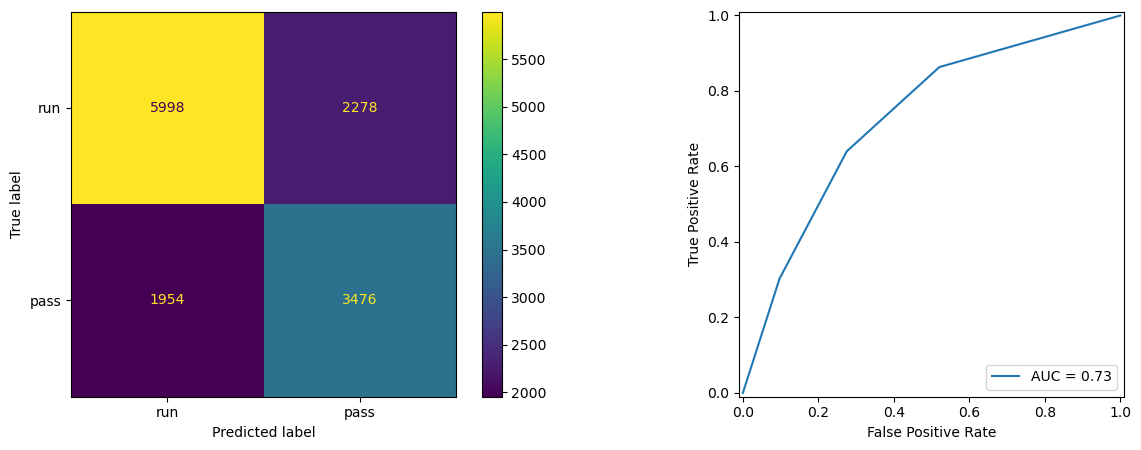

In [32]:
model_name = f"RandomForestClassifier with (n_estimators={random_forest__n_estimators}, max_features={random_forest__max_features})"
model = RandomForestClassifier(n_estimators=random_forest__n_estimators, 
                               max_features=random_forest__max_features,
                               oob_score=True)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "rf").run()

### Gradient Boosting Ensemble

Precision: 0.6923
Recall: 0.6341


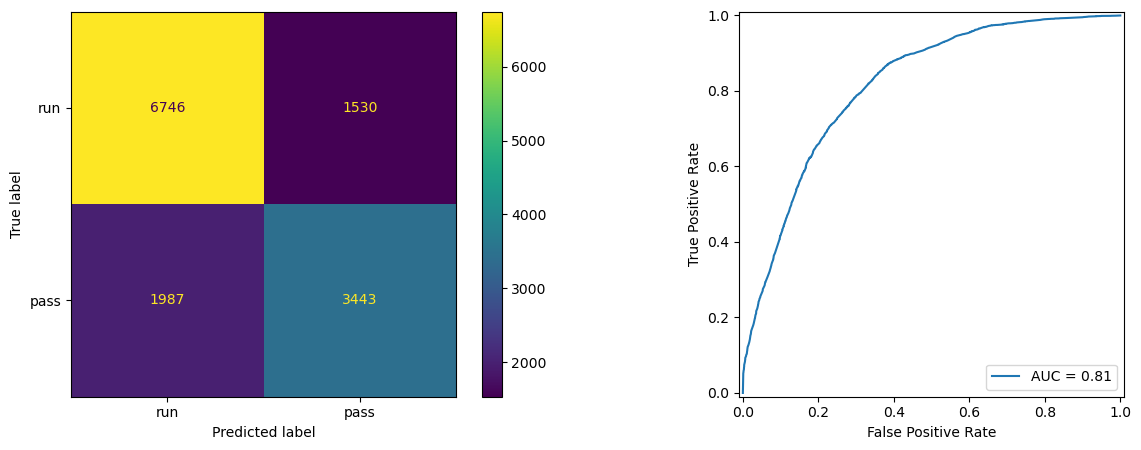

In [33]:
model_name = f"GradientBoostingClassifier with (n_estimators={gradient_boost__n_estimators})"
model = GradientBoostingClassifier(n_estimators=gradient_boost__n_estimators)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "gb").run()

# Summary

In [34]:
print_best_params("All Hyperparameters", all_best_params)
print_best_features()
show_run_output()

*Best Run is 0.743689 from LogisticRegression (fit_intercept = True, penalty = l2, C = 1.0, class_weight = None, solver = newton-cholesky)*

| Model | Features | Train Time | Train Accuracy | Test Accuracy |
| ----- | -------- | ---------- | -------------  | -----------   |
| Dummy | 0 | 0.0089 secs | 0.603805 | 0.603823 |
| LogisticRegression (fit_intercept = True, penalty = l2, C = 1.0, class_weight = None, solver = newton-cholesky) | 29 | 0.0144 secs | 0.741935 | 0.743689 |
| K-Nearest Neighbors (algorithm = auto, n_neighbors = 10, weights = None) | 29 | 0.1744 secs | 0.740281 | 0.740479 |
| DecisionTreeClassifier with (criterion=entropy, max_depth=6, max_features=None) | 29 | 0.0118 secs | 0.746071 | 0.742959 |
| SVM (default params) | 29 | 0.0160 secs | 0.767577 | 0.730045 |
| RandomForestClassifier with (n_estimators=3, max_features=6) | 29 | 0.0200 secs | 0.938792 | 0.691230 |
| GradientBoostingClassifier with (n_estimators=32) | 29 | 0.0733 secs | 0.753929 | 0.743397 |


In [ ]:
X_test["actual"] = y_test
X_test['lr_acc'] = X_test.apply(lambda p: p.lr_pred == p.actual, axis = 1)   
X_test[model_acc] = X_test.apply(lambda p: p.lr_pred == p.actual, axis = 1) 
X_test['kn_acc'] = X_test.apply(lambda p: p.kn_pred == p.actual, axis = 1)   
X_test['dt_acc'] = X_test.apply(lambda p: p.dt_pred == p.actual, axis = 1)   
X_test['sv_acc'] = X_test.apply(lambda p: p.sv_pred == p.actual, axis = 1)   
X_test['rf_acc'] = X_test.apply(lambda p: p.rf_pred == p.actual, axis = 1)   
X_test['gb_acc'] = X_test.apply(lambda p: p.gb_pred == p.actual, axis = 1)   

X_test.columns

Index(['yardsToGo', 'secs_remaining', 'is_inside_two_mins', 'wr_count',
       'te_count', 'rb_count', 'extra_ol', 'on_schedule', 'and_short',
       'score_offset', 'win_probability', 'form_EMPTY', 'form_I_FORM',
       'form_JUMBO', 'form_MUDDLE', 'form_PISTOL', 'form_SHOTGUN',
       'form_SINGLEBACK', 'form_VICTORY', 'form_WILDCAT', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'down_1', 'down_2',
       'down_3', 'down_4', 'lr_pred', 'kn_pred', 'dt_pred', 'sv_pred',
       'rf_pred', 'gb_pred', 'actual', 'lr_acc', 'kn_acc', 'dt_acc', 'sv_acc',
       'rf_acc', 'gb_acc'],
      dtype='object')

In [44]:
print("| Model | EMPTY | I_FORM | JUMBO | MUDDLE | PISTOL | SHOTGUN | SINGLEBACK | VICTORY | WILDCAT |")
print("| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |")
form_best_acc = {}
form_best_model = {}
for prefix in ['lr', 'kn', 'dt', 'sv', 'rf', 'gb']:
    model_acc = f'{prefix}_acc'
    row = f"| {prefix} | "
    for form in ['EMPTY', 'I_FORM', 'JUMBO', 'MUDDLE', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'VICTORY', 'WILDCAT']:
        form_col = f'form_{form}'
        mean_acc = X_test[X_test[form_col] == 1][model_acc].mean()
        row += f"{mean_acc:.4f} | "
        if form not in form_best_acc or mean_acc > form_best_acc[form]:
            form_best_acc[form] = mean_acc
            form_best_model[form] = prefix
    print(row)

print(form_best_acc)
print(form_best_model)

total_recs = 0
total_accurate = 0
for form in ['EMPTY', 'I_FORM', 'JUMBO', 'MUDDLE', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'VICTORY', 'WILDCAT']:
    recs = X_test[X_test[f'form_{form}'] == 1].shape[0]
    print(f"Total Records - {form}: {recs}")
    total_recs += recs
    total_accurate += recs * form_best_acc[form]

print(f"Overall Accuracy of Best by Formation: {total_accurate / total_recs:.4f}")

| Model | EMPTY | I_FORM | JUMBO | MUDDLE | PISTOL | SHOTGUN | SINGLEBACK | VICTORY | WILDCAT |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| lr | 0.9665 | 0.7138 | 0.8426 | 1.0000 | 0.6552 | 0.7464 | 0.6658 | 1.0000 | 0.8378 | 
| kn | 0.9665 | 0.7149 | 0.8426 | 0.0476 | 0.6438 | 0.7456 | 0.6616 | 1.0000 | 0.8514 | 
| dt | 0.9656 | 0.7103 | 0.8426 | 1.0000 | 0.6610 | 0.7468 | 0.6655 | 1.0000 | 0.6892 | 
| sv | 0.9550 | 0.7034 | 0.8148 | 0.4762 | 0.6800 | 0.7294 | 0.6553 | 0.9728 | 0.8649 | 
| rf | 0.9259 | 0.6431 | 0.6667 | 0.7143 | 0.6190 | 0.7053 | 0.5918 | 1.0000 | 0.6622 | 
| gb | 0.9665 | 0.7080 | 0.7963 | 0.0000 | 0.7029 | 0.7509 | 0.6586 | 1.0000 | 0.7297 | 
{'EMPTY': np.float64(0.9664902998236331), 'I_FORM': np.float64(0.7149478563151797), 'JUMBO': np.float64(0.8425925925925926), 'MUDDLE': np.float64(1.0), 'PISTOL': np.float64(0.7028571428571428), 'SHOTGUN': np.float64(0.7509020446345048), 'SINGLEBACK': np.float64(0.6657714115189496), 'VICTORY': np.f